In [6]:
import os
import glob
import re
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import joblib
from sklearn.decomposition import PCA
import pandas as pd

In [3]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

In [4]:
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [7]:
# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'image_name': image_name})


[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif']


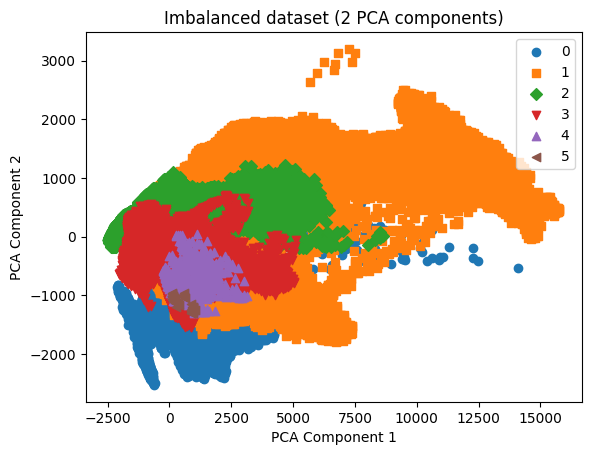

In [8]:
# Normalize the features if necessary
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# features_normalized = scaler.fit_transform(features)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

# Function to plot 2D space
def plot_2d_space(X, y, label='Classes'):
    colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']
    markers = ['o', 's', 'D', 'v', '^', '<', '>', '8', 'p', '*']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Plot the PCA transformed data
plot_2d_space(X_pca, encoded_labels, 'Imbalanced dataset pca')


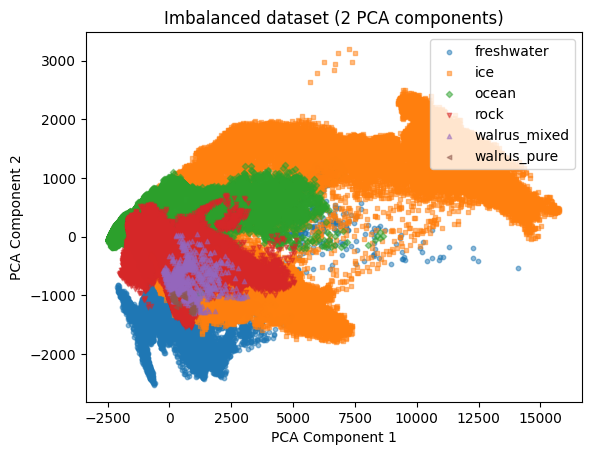

In [9]:
# Normalize the features if necessary
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# features_normalized = scaler.fit_transform(features)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

# Function to plot 2D space
def plot_2d_space(X, y, label='Classes', class_names=None):
    colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']
    markers = ['o', 's', 'D', 'v', '^', '<', '>', '8', 'p', '*']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=class_names[l] if class_names is not None else l, marker=m, s=10, alpha=0.5
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Get class names for the legend
class_names = le.inverse_transform(np.unique(encoded_labels))

# Plot the PCA transformed data
plot_2d_space(X_pca, encoded_labels, 'Imbalanced dataset (2 PCA components)', class_names)


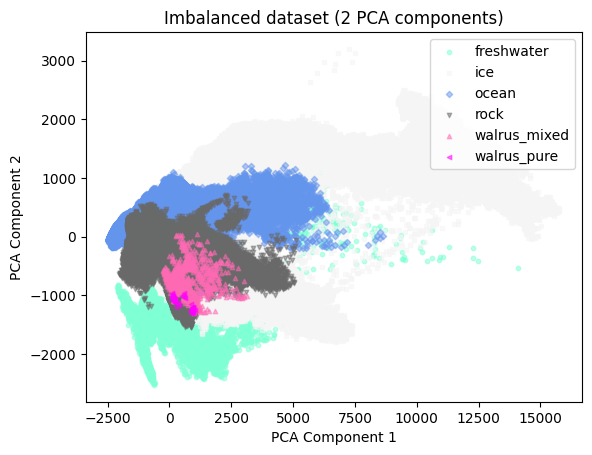

In [12]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

# Define a color map for the labels
label_colors = {'ice': 'whitesmoke', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'aquamarine', 'ocean': 'cornflowerblue'}
encoded_class_names = le.classes_
class_color_map = {encoded_class_names[i]: label_colors[encoded_class_names[i]] for i in range(len(encoded_class_names))}

# Function to plot 2D space
def plot_2d_space(X, y, label='Classes', class_names=None, color_map=None):
    markers = ['o', 's', 'D', 'v', '^', '<', '>', '8', 'p', '*']
    for l, m in zip(np.unique(y), markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=color_map[class_names[l]] if color_map else 'black',
            label=class_names[l] if class_names is not None else l,
            marker=m,
            s=10,
            alpha=0.5
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Get class names for the legend
class_names = le.inverse_transform(np.unique(encoded_labels))

# Plot the PCA transformed data
plot_2d_space(X_pca, encoded_labels, 'Imbalanced dataset (2 PCA components)', class_names, class_color_map)


In [13]:
import glob
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import geometry_mask
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
import joblib
import matplotlib.colors as mcolors

In [14]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [15]:
# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

In [16]:
# Calculate and print the number of pixels for each class in the training and test datasets
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Calculate class distributions
print_class_distribution(train_df, "Training")
print_class_distribution(test_df, "Test")



Training Class Distribution:
ocean: 623431
ice: 240185
rock: 74284
freshwater: 32201
walrus_mixed: 657
walrus_pure: 38

Test Class Distribution:
ocean: 155857
ice: 60046
rock: 18572
freshwater: 8050
walrus_mixed: 165
walrus_pure: 10


In [18]:
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import numpy as np

# Apply Tomek Links under-sampling
tl = TomekLinks(return_indices=True, ratio='majority')
X_train_resampled, y_train_resampled, id_tl = tl.fit_sample(X_train, y_train)

print('Removed indexes:', id_tl)

# Function to plot 2D space
def plot_2d_space(X, y, label='Classes'):
    colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B']
    markers = ['o', 's', 'p', 'P', 'h', 'X']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

# Plot the resampled data
plot_2d_space(X_train_resampled, y_train_resampled, 'Tomek links under-sampling')


TypeError: __init__() got an unexpected keyword argument 'return_indices'

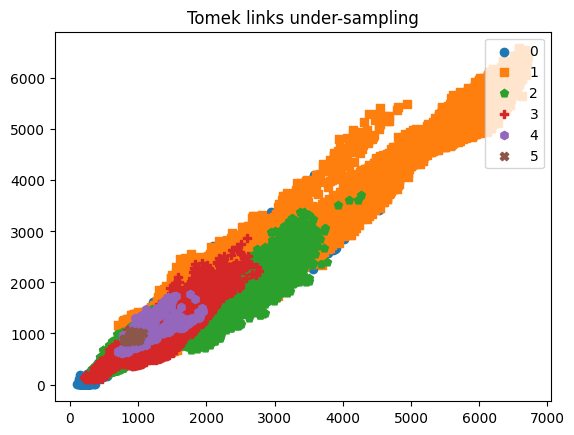

In [19]:
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already defined X_train, y_train, X_test, y_test

# Apply Tomek Links under-sampling
tl = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tl.fit_resample(X_train, y_train)

# Function to plot 2D space
def plot_2d_space(X, y, label='Classes'):
    colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B']
    markers = ['o', 's', 'p', 'P', 'h', 'X']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

# Plot the resampled data
plot_2d_space(X_train_resampled, y_train_resampled, 'Tomek links under-sampling')


In [22]:
# Calculate the number of pixels in each class for the resampled training data
unique_classes, counts = np.unique(y_train_resampled, return_counts=True)

# Print the class distribution
print("Resampled Training Class Distribution:")
for label, count in zip(unique_classes, counts):
    print(f"{le.classes_[label]}: {count}")

Resampled Training Class Distribution:
freshwater: 32201
ice: 240185
ocean: 623076
rock: 74284
walrus_mixed: 657
walrus_pure: 38


In [17]:
# Calculate and print the number of pixels from each island in the test dataset
def print_island_distribution(df):
    islands = df['image_name'].apply(lambda x: extract_island_and_date(os.path.basename(x))[0])
    island_counts = islands.value_counts()
    print("\nTest Dataset Island Distribution:")
    for island, count in island_counts.items():
        print(f"{island}: {count}")

# Print image names used in the test data and the number of pixels from each island
def print_test_images_info(df):
    print("\nTest Dataset Image Names and Pixel Counts:")
    image_names = df['image_name'].unique()
    for image_name in image_names:
        image_pixel_count = (df['image_name'] == image_name).sum()
        print(f"Image: {os.path.basename(image_name)}, Pixels: {image_pixel_count}")

# Print island distribution and test images info
print_island_distribution(test_df)
print_test_images_info(test_df)



Test Dataset Island Distribution:
buch: 110509
tor: 54748
pal: 34007
sars: 30084
moff: 13352

Test Dataset Image Names and Pixel Counts:
Image: buch_20230714_image.tif, Pixels: 23561
Image: buch_20230720_image.tif, Pixels: 37126
Image: buch_20230731_image.tif, Pixels: 34912
Image: buch_20230923_image.tif, Pixels: 14910
Image: moff_20230717_image.tif, Pixels: 13352
Image: pal_20230714_image.tif, Pixels: 12674
Image: pal_20230720_image.tif, Pixels: 5710
Image: pal_20230726_image.tif, Pixels: 15623
Image: sars_20230714_image.tif, Pixels: 14871
Image: sars_20230803_image.tif, Pixels: 15213
Image: tor_20230801_image.tif, Pixels: 14920
Image: tor_20230824_image.tif, Pixels: 12097
Image: tor_20230901_image.tif, Pixels: 16752
Image: tor_20230902_image.tif, Pixels: 10979


In [ ]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the model
model_filename = "RF_allislands_balanced.joblib"
joblib.dump(model, model_filename)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()
